<a href="https://colab.research.google.com/github/francescakaganzi/MachineLearning/blob/main/Eng_Traffic_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Francesca Kaganzi
2023/HDO5/0669U**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, classification_report,ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
directory_path = '/content/drive/MyDrive/Traffic_Monitoring/dataset_images'
images = []
labels = []
classes = os.listdir(directory_path)

for subdir, dirs, files in os.walk(directory_path):
        for file in tqdm(files):
            # Read the image
            image_path = os.path.join(subdir, file)
            image = cv2.imread(image_path)
            #image = cv2.resize(image, (32, 32))  # Resize
            images.append(image)
            # Extract label from the image's parent directory
            label = os.path.basename(subdir)
            labels.append(label)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

0it [00:00, ?it/s]
100%|██████████| 263/263 [00:05<00:00, 45.88it/s]


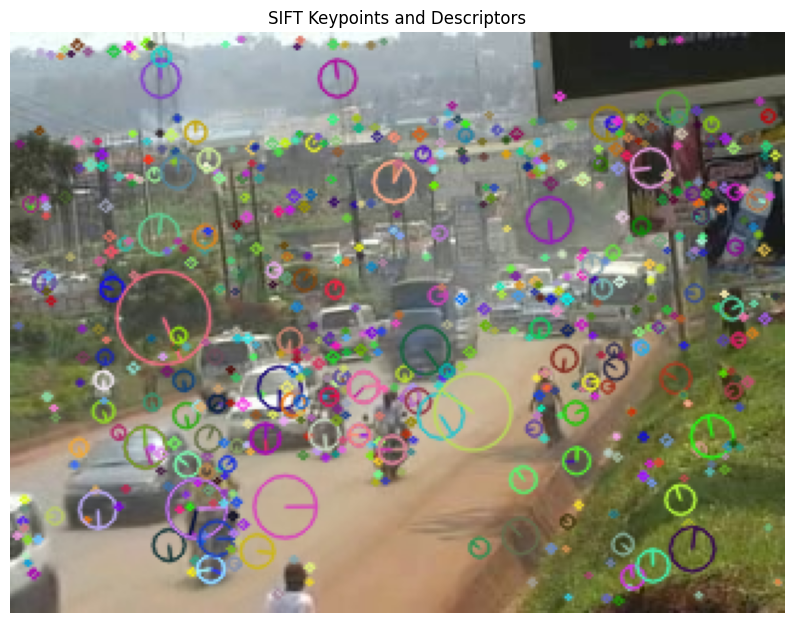

Number of keypoints detected: 744
Descriptors shape: (744, 128)
Descriptors:
 [[  0.   0.   0. ... 105.  98.  38.]
 [  1.   0.   0. ...   0.   1.  15.]
 [ 12.  14.   7. ...   0.   1.  45.]
 ...
 [  0.   0.   5. ...   3.   0.   5.]
 [  0.   0.   4. ...  56.   4.   9.]
 [  5.   0.   3. ...   5.  28.  56.]]


In [ ]:
# Read the image
image_path = '/content/drive/MyDrive/Traffic_Monitoring/dataset_images/Motorcycle/frame_394.jpg'  # Replace with your image path
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints, descriptors = sift.detectAndCompute(gray_image, None)

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('SIFT Keypoints and Descriptors')
plt.axis('off')
plt.show()

# If you want to print the descriptors
print("Number of keypoints detected:", len(keypoints))
print("Descriptors shape:", descriptors.shape)
print("Descriptors:\n", descriptors)

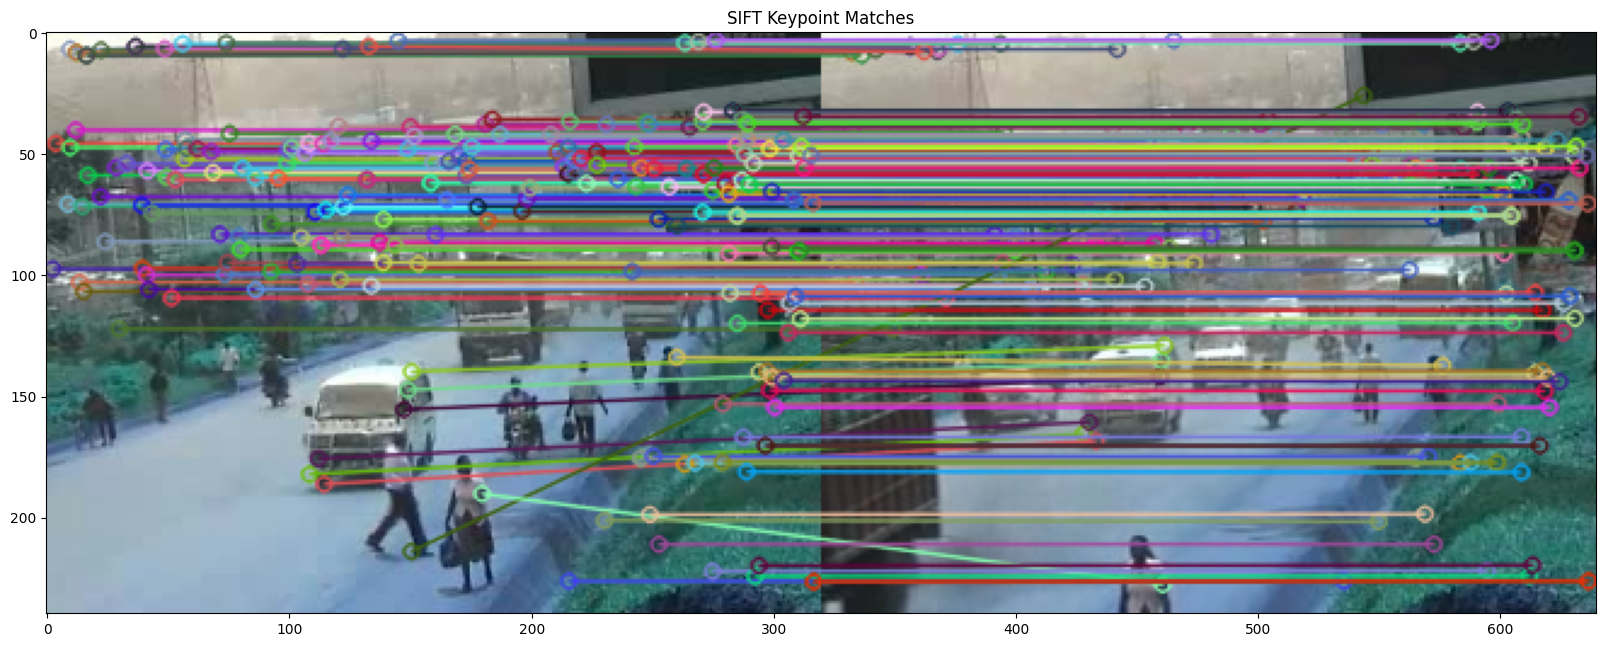

In [ ]:
# Image visualisation and matching using the SIFT features
def sift_keypoints_and_matches(img1_path, img2_path):
    # Load the images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Check if images are loaded
    if img1 is None or img2 is None:
        print("Error: One or both images failed to load.")
        return

    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Use FLANN based matcher for finding matches
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Store only good matches using Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Draw matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the result
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matches)
    plt.title('SIFT Keypoint Matches')
    plt.show()

# Example usage
img1_path = '/content/drive/MyDrive/Traffic_Monitoring/dataset_images/Truck/frame_0.jpg'
img2_path = '/content/drive/MyDrive/Traffic_Monitoring/dataset_images/Motorcycle/frame_217.jpg'
sift_keypoints_and_matches(img1_path, img2_path)


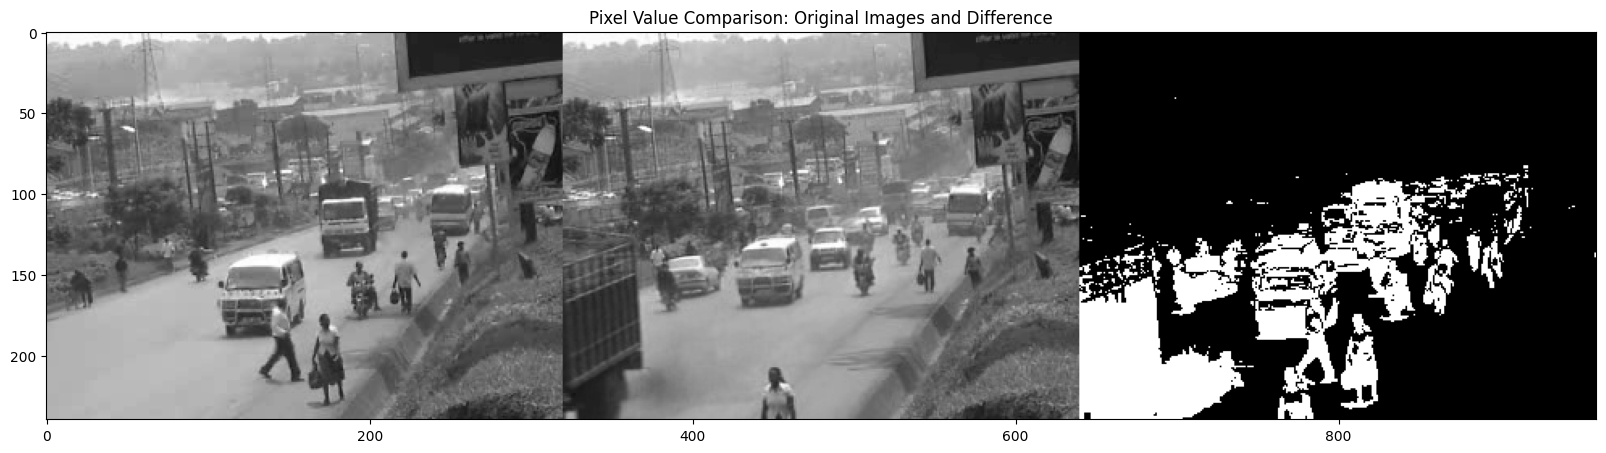

In [ ]:
#comparision between frames using the Pixel value features

def pixel_value_comparison(img1_path, img2_path):
    # Load the images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Check if images are loaded
    if img1 is None or img2 is None:
        print("Error: One or both images failed to load.")
        return

    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Ensure the images are of the same size
    if gray1.shape != gray2.shape:
        print("Error: Images are not of the same size.")
        return

    # Compute absolute difference between images
    diff = cv2.absdiff(gray1, gray2)

    # Apply a threshold to highlight the differences
    _, diff_thresholded = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Stack images and differences for visualization
    stacked_images = np.hstack((gray1, gray2, diff_thresholded))

    # Display the result
    plt.figure(figsize=(20, 10))
    plt.imshow(stacked_images, cmap='gray')
    plt.title('Pixel Value Comparison: Original Images and Difference')
    plt.show()

# Example usage
img1_path = '/content/drive/MyDrive/Traffic_Monitoring/dataset_images/Truck/frame_0.jpg'
img2_path = '/content/drive/MyDrive/Traffic_Monitoring/dataset_images/Motorcycle/frame_217.jpg'
pixel_value_comparison(img1_path, img2_path)


In [ ]:
# Extract SIFT features
sift = cv2.SIFT_create()

train_descriptors = []
train_pixels = []

for img in train_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    pixel_values = img.flatten()  # Flatten pixel values
    combined_features = np.hstack((descriptors, pixel_values[:descriptors.shape[0] * 3].reshape(-1, 3)))  # Concatenate SIFT descriptors and pixel values
    train_descriptors.append(combined_features)
np.vstack(train_descriptors).shape

# Cluster SIFT descriptors and pixel values into visual words
kmeans = KMeans(n_clusters=20, n_init='auto')
kmeans.fit(np.vstack(train_descriptors))

# Generate histograms for each image using the visual words
train_histograms = []
for descriptors in train_descriptors:
    visual_words = kmeans.predict(descriptors)
    histogram, _ = np.histogram(visual_words, bins=np.arange(101))
    train_histograms.append(normalize(histogram.reshape(1, -1)))


In [ ]:
# Repeat the same process for test images
test_descriptors = []
test_pixels = []

for img in test_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    pixel_values = img.flatten()
    combined_features = np.hstack((descriptors, pixel_values[:descriptors.shape[0] * 3].reshape(-1, 3)))
    test_descriptors.append(combined_features)


test_histograms = []
for descriptors in test_descriptors:
    visual_words = kmeans.predict(descriptors)
    histogram, _ = np.histogram(visual_words, bins=np.arange(101))
    test_histograms.append(normalize(histogram.reshape(1, -1)))

In [ ]:
import pickle
with open('test_histograms.pkl', 'wb') as f:
    pickle.dump(test_histograms, f)

with open('train_histograms.pkl', 'wb') as f:
    pickle.dump(train_histograms, f)

with open('train_labels.pkl', 'wb') as f:
    pickle.dump(train_labels, f)

with open('test_labels.pkl', 'wb') as f:
    pickle.dump(test_labels, f)

In [ ]:
#Labels encoding
label_encoder = LabelEncoder()
label_encoder.fit(test_labels)
test_labels_encoded=label_encoder.transform(test_labels)
train_labels_encoded=label_encoder.transform(train_labels)

In [ ]:
# Define global variables
results = {}
results_df = pd.DataFrame()

def train_and_predict(model):
    """
    Trains the model on the training data and returns the predictions on the test data.

    Args:
        X_train: The training data.
        y_train: The training labels.
        X_test: The test data.
        y_test: The test labels.

    Returns:
        None
    """
    global results
    global results_df
    # Train the model on the training data
    model.fit(np.vstack(train_histograms), train_labels)

    # Make predictions on the test data
    y_pred = model.predict(np.vstack(test_histograms))

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create confusion matrix
    cm_dt = confusion_matrix(test_labels, y_pred )
    cm_display_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=classes)
    cm_display_dt.plot(ax=ax)

    # Title of the confusion matrix plot
    plt.title(f"Confusion Matrix for: {model.__class__.__name__}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    print("Confusion Matrix:")
    plt.show()

    # Compute and plot the ROC curve and AUC
    YtestDTProba = model.predict_proba(np.vstack(test_histograms))

    # Convert y_test to a one-dimensional NumPy array
    y_test_array = test_labels_encoded

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 4

    # Compute the ROC curve and AUC for each class
    for i, cls_name in zip(range(n_classes), classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_array == i, YtestDTProba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class with a different color
    for i, cls_name in zip(range(n_classes), classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {cls_name} ROC curve (area = {roc_auc[i]:0.2f})')

    # Dashed line representing the reference line
    plt.plot([0, 1], [0, 1], 'k--')

    # Add legends and axis labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for all Classes')
    plt.legend(loc="lower right")
    plt.show()

    # Compute the mean AUC for all classes
    mean_auc = np.mean(list(roc_auc.values()))

    # Save the results in the corresponding dictionary

    results[model.__class__.__name__] = [
        accuracy_score(test_labels, y_pred),
        precision_score(test_labels, y_pred, average='weighted'),
        recall_score(test_labels, y_pred, average='weighted'),
        f1_score(test_labels, y_pred, average='weighted'),
        str(round(mean_auc, 3)),
    ]

    # Convert results dictionaries to DataFrames for display
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])

    print(classification_report(test_labels, y_pred))
    return None


Confusion Matrix:


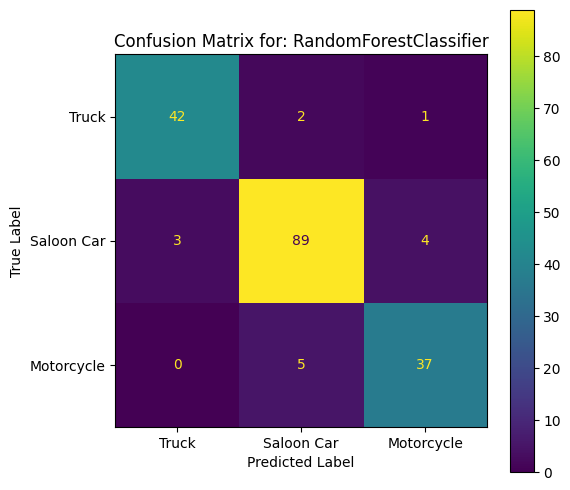

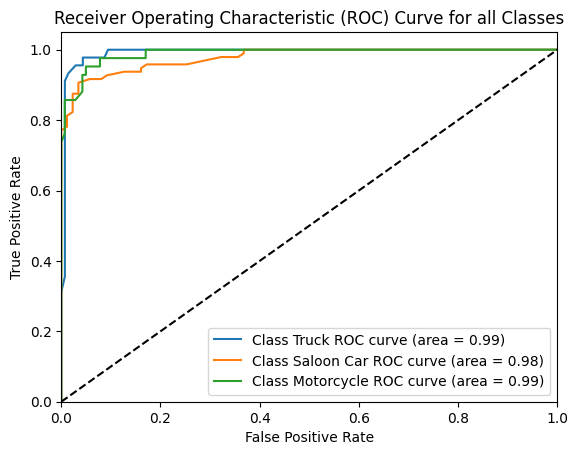

              precision    recall  f1-score   support

  Motorcycle       0.93      0.93      0.93        45
  Saloon Car       0.93      0.93      0.93        96
       Truck       0.88      0.88      0.88        42

    accuracy                           0.92       183
   macro avg       0.91      0.91      0.91       183
weighted avg       0.92      0.92      0.92       183



In [ ]:
train_and_predict(RandomForestClassifier(n_estimators=100, random_state=42))

Confusion Matrix:


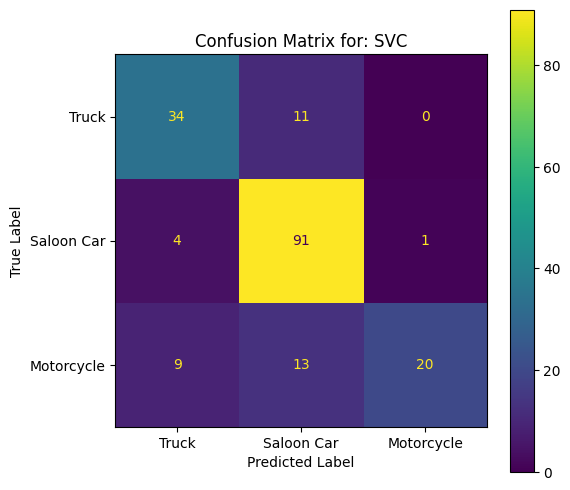

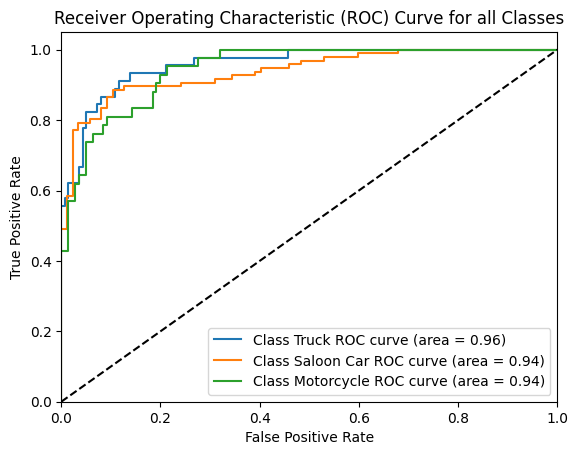

              precision    recall  f1-score   support

  Motorcycle       0.72      0.76      0.74        45
  Saloon Car       0.79      0.95      0.86        96
       Truck       0.95      0.48      0.63        42

    accuracy                           0.79       183
   macro avg       0.82      0.73      0.75       183
weighted avg       0.81      0.79      0.78       183



In [ ]:
train_and_predict(SVC(kernel='linear', degree=3, probability=True, random_state=42))

Confusion Matrix:


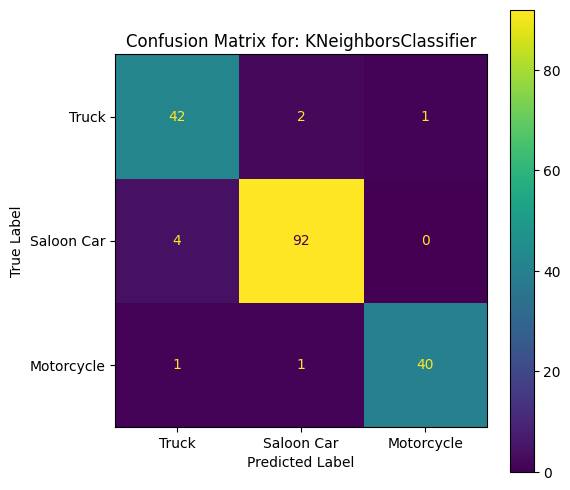

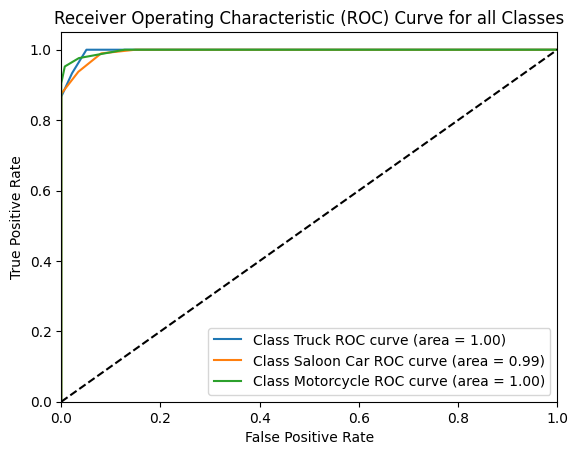

              precision    recall  f1-score   support

  Motorcycle       0.89      0.93      0.91        45
  Saloon Car       0.97      0.96      0.96        96
       Truck       0.98      0.95      0.96        42

    accuracy                           0.95       183
   macro avg       0.95      0.95      0.95       183
weighted avg       0.95      0.95      0.95       183



In [ ]:
train_and_predict(KNeighborsClassifier(n_neighbors=5))

Confusion Matrix:


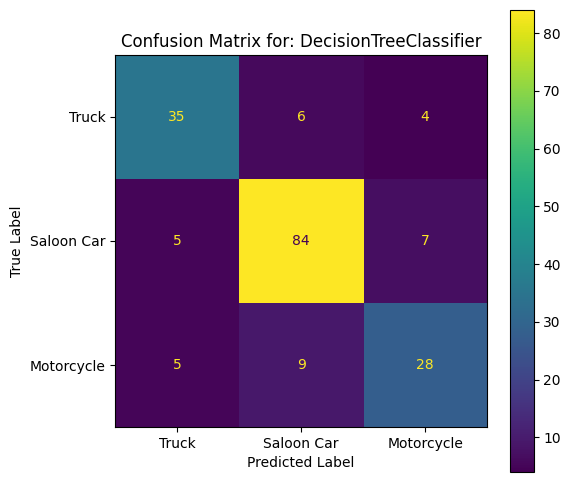

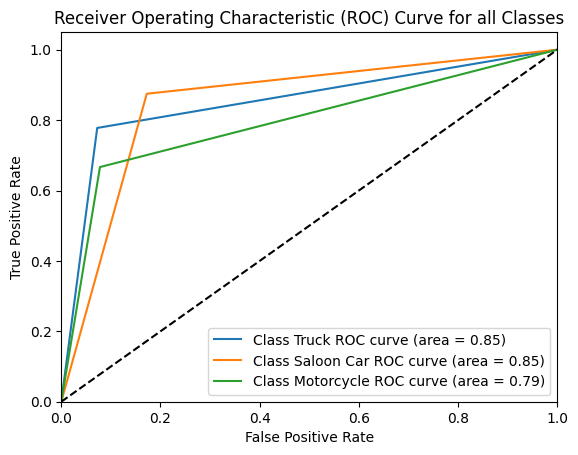

              precision    recall  f1-score   support

  Motorcycle       0.78      0.78      0.78        45
  Saloon Car       0.85      0.88      0.86        96
       Truck       0.72      0.67      0.69        42

    accuracy                           0.80       183
   macro avg       0.78      0.77      0.78       183
weighted avg       0.80      0.80      0.80       183



In [ ]:
train_and_predict(DecisionTreeClassifier(random_state=42))

Confusion Matrix:


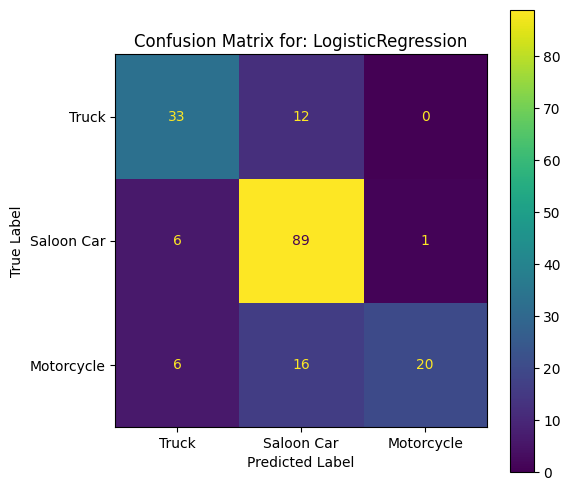

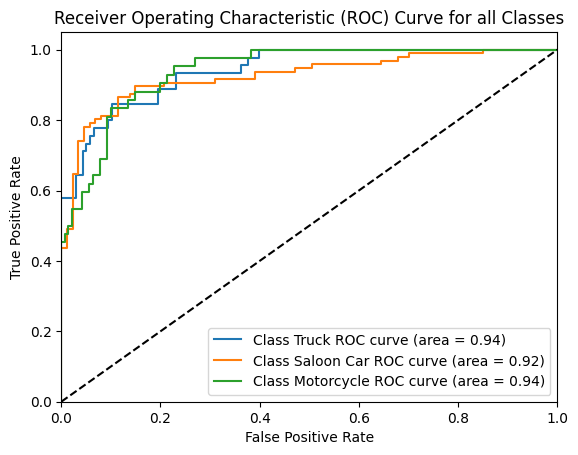

              precision    recall  f1-score   support

  Motorcycle       0.73      0.73      0.73        45
  Saloon Car       0.76      0.93      0.84        96
       Truck       0.95      0.48      0.63        42

    accuracy                           0.78       183
   macro avg       0.82      0.71      0.73       183
weighted avg       0.80      0.78      0.76       183



In [ ]:
train_and_predict(LogisticRegression(solver='lbfgs', random_state=42))

Confusion Matrix:


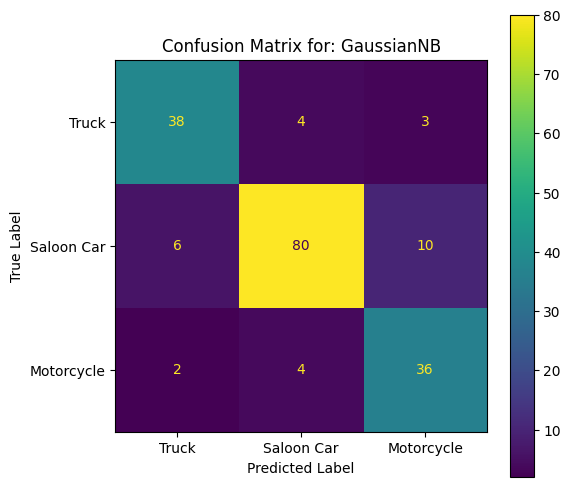

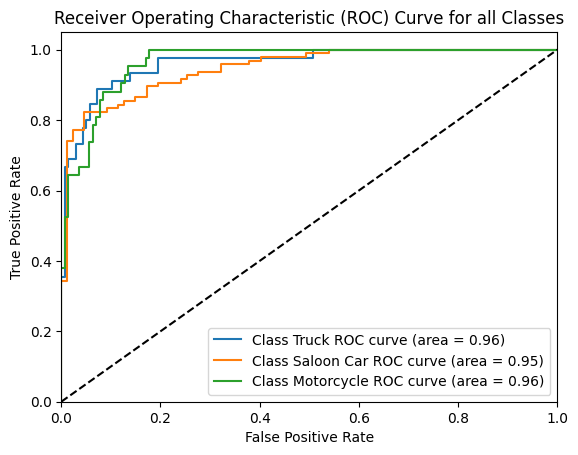

              precision    recall  f1-score   support

  Motorcycle       0.83      0.84      0.84        45
  Saloon Car       0.91      0.83      0.87        96
       Truck       0.73      0.86      0.79        42

    accuracy                           0.84       183
   macro avg       0.82      0.84      0.83       183
weighted avg       0.85      0.84      0.84       183



In [ ]:
train_and_predict(GaussianNB())

In [ ]:
results_df

,Accuracy,Precision,Recall,F1-Score,AUC
RandomForestClassifier,0.918033,0.918033,0.918033,0.918033,0.986
SVC,0.792350,0.811576,0.792350,0.779963,0.947
KNeighborsClassifier,0.950820,0.951676,0.950820,0.951096,0.996
DecisionTreeClassifier,0.803279,0.801139,0.803279,0.801884,0.833
LogisticRegression,0.775956,0.797954,0.775956,0.764437,0.935
GaussianNB,0.841530,0.848655,0.841530,0.843123,0.958


Confusion Matrix:


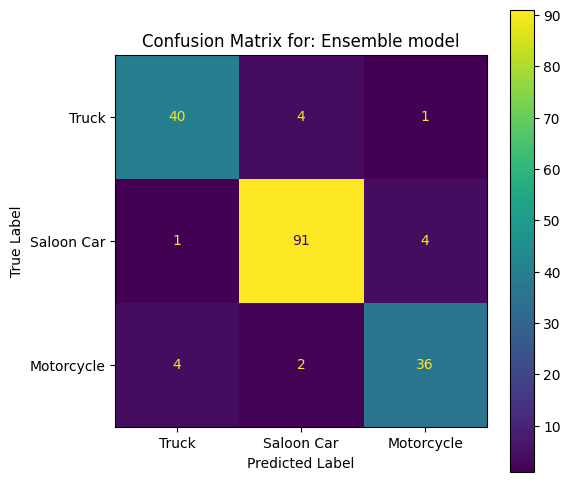

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        45
           1       0.94      0.95      0.94        96
           2       0.88      0.86      0.87        42

    accuracy                           0.91       183
   macro avg       0.90      0.90      0.90       183
weighted avg       0.91      0.91      0.91       183



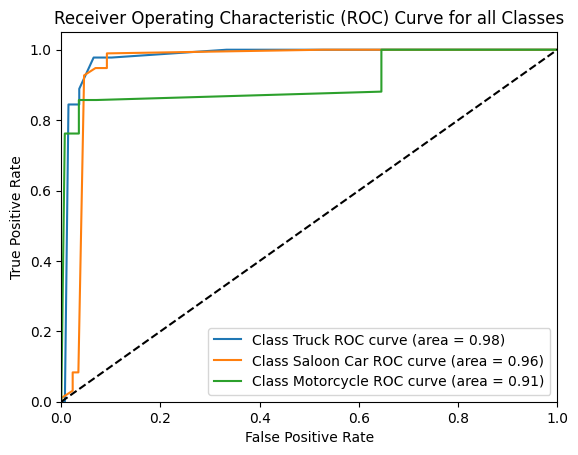

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have already trained three models: model1, model2, and model3

# Combine the predictions of the three models
def ensemble_predictions(models, X):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))
    return predictions

# Convert the predictions into a matrix format
def create_ensemble_matrix(predictions):
    return np.array(predictions).T

#model1=RandomForestClassifier(n_estimators=75, random_state=42)
model1=RandomForestClassifier(n_estimators=100, random_state=42)
model2=KNeighborsClassifier(n_neighbors=5)
#model3=SVC(kernel='linear', degree=3, probability=True, random_state=42)
model3=GaussianNB()

# Train the model on the training data
model1.fit(np.vstack(train_histograms), train_labels_encoded)
model2.fit(np.vstack(train_histograms), train_labels_encoded)
model3.fit(np.vstack(train_histograms), train_labels_encoded)

# Create an ensemble of the three best performing models
models = [model1, model2, model3]

# Make predictions on the test set using the ensemble
ensemble_preds = ensemble_predictions(models, np.vstack(test_histograms))

# Convert predictions into a matrix format
ensemble_matrix = create_ensemble_matrix(ensemble_preds)

# Train AdaBoost on the ensemble predictions
ada_boost = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_boost.fit(ensemble_matrix, test_labels_encoded)

# Evaluate the ensemble model
ensemble_predictions = ada_boost.predict(ensemble_matrix)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))

# Create confusion matrix
cm_dt = confusion_matrix(test_labels_encoded, ensemble_predictions)
cm_display_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=classes)
cm_display_dt.plot(ax=ax)
name="Ensemble model"

# Title of the confusion matrix plot
plt.title(f"Confusion Matrix for: {name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("Confusion Matrix:")
plt.show()
print("Classification Report:")
print(classification_report(test_labels_encoded, ensemble_predictions))


# Convert y_test to a one-dimensional NumPy array
y_test_array = test_labels_encoded

# Compute and plot the ROC curve and AUC
YtestDTProba = ada_boost.predict_proba(ensemble_matrix)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4


# Compute the ROC curve and AUC for each class
for i, cls_name in zip(range(n_classes), classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_array == i, YtestDTProba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class with a different color
for i, cls_name in zip(range(n_classes), classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {cls_name} ROC curve (area = {roc_auc[i]:0.2f})')

# Dashed line representing the reference line
plt.plot([0, 1], [0, 1], 'k--')

# Add legends and axis labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for all Classes')
plt.legend(loc="lower right")
plt.show()